#** Google Stock Price Dataset **
Goal: Use Time Series model to fit Google Stock Price

## **STEP 1: Load Packages and Load Data**



In [0]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [20,8]

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Copy of Google_Stock_Price_Train.csv to Copy of Google_Stock_Price_Train (2).csv


In [0]:
stock = pd.read_csv('Copy of Google_Stock_Price_Train.csv')
stock.head()

,Date,Open,High,Low,Close,Volume
0,26-Sep-17,936.69,944.08,935.12,937.43,1672749
1,25-Sep-17,939.45,939.75,924.51,934.28,1873375
2,22-Sep-17,942.77,950.00,940.84,943.26,1074806
3,21-Sep-17,948.13,952.80,939.38,947.55,1370685
4,20-Sep-17,937.73,950.00,937.50,947.54,2004018


## STEP 2: Data Exploration

In [0]:
# first, I print out the basic information
stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


From the summary above, there are 6 columns in total and 1258 non-null data points, which is a fairly small and clean dataset. However, for time series modeling, the "Date" column should be the index and be "Datetime" datatype.

In [0]:
stock['Date']= stock['Date'].astype('datetime64[ns]')
stock.set_index('Date',inplace=True)

In [0]:
stock.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,631.416161,636.062377,626.047448,631.197146,2.045335e+06
std,172.303143,173.188390,171.150477,172.290932,1.069595e+06
min,323.320000,326.830000,318.320000,323.910000,5.211410e+05
25%,523.062500,527.510000,517.820000,521.775000,1.426658e+06
50%,587.295000,589.930000,581.985000,586.450000,1.788089e+06
75%,769.927500,776.990000,762.282500,769.537500,2.313565e+06
max,1005.490000,1008.610000,996.620000,1004.280000,1.285814e+07


Since the goal is to build a time series model for stock price, the target there is the "Close" Price.

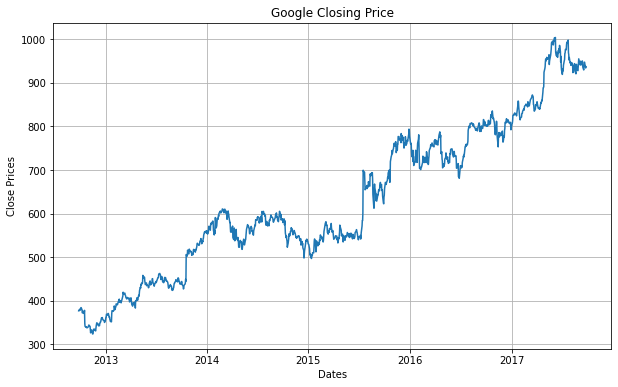

In [0]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(stock.Close)
plt.title('Google Closing Price')
plt.show()

From the line chart above, the given time series is thought to have some systematic components. For example, trend, seasonality and noise. 

## STEP 3: Check the stationarity

Now, I'm going to check if this series is stationary or not because time series analysis only works with stationary data. 

I'm going to use ADF (Augmented Dickey-Fuller) Test, which is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help me understand if the series is stationary or not. 

The null and alternate hypothesis of this test is:

  - H0: The series has a unit root (value of a =1)
  
  - H1: The series has no unit root.

If I fail to reject the null hypothesis (P-value>0.05), I can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

So let's check for stationarity:

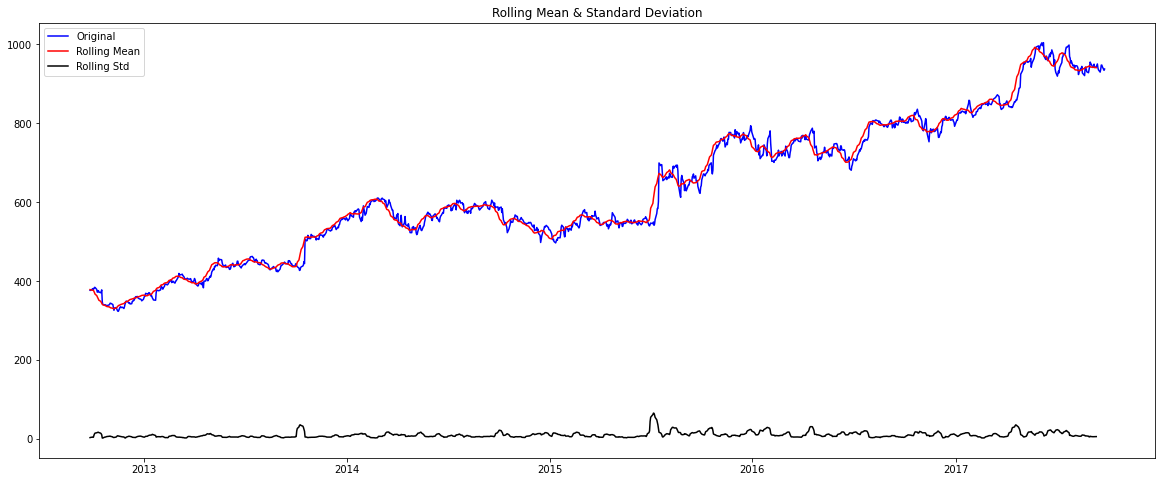

Results of Dickey-Fuller Test:
Test Statistic            -1.167719
p-value                    0.687326
# Lags Used                0.000000
# Observations Used     1257.000000
Critical Value (1%)       -3.435563
Critical Value (5%)       -2.863842
Critical Value (10%)      -2.567996
dtype: float64


In [0]:
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() 
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    # output for dft will give us answers without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','# Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(stock.Close)

Through the above graph, the rolling mean and standard deviation keep increasing. Hence the Google series is not stationary.

More than that, the results of Dickey-fuller test shows p-value=0.687326 is greater than 0.05 so I cannot reject the Null hypothesis. Also, the test statistics=-1.167719 is greater than the critical values. So the data is non-stationary.


## STEP 4: Transform Stationary

In order to perform a time series analysis, the stationary data is necessary so seasonality and trend need to be removed from the series. The residuel series will become stationary through the following process.

So let us separate Trend and Seasonality from the time series.

### 4.1 Moving Average

There are also many ways to do this.

I start by finding the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

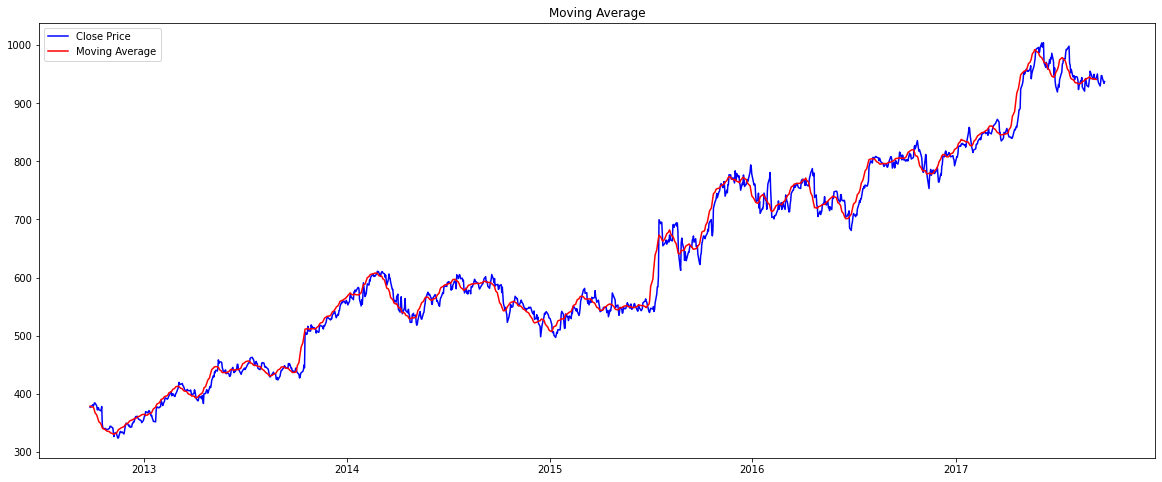

In [0]:
moving_avg = stock['Close'].rolling(12).mean()
plt.plot(stock.Close,color='blue',label='Close Price')
plt.plot(moving_avg, color='red',label='Moving Average')
plt.title('Moving Average')
plt.legend(loc='best')

In [0]:
moving_avg_diff = stock.Close - moving_avg
moving_avg_diff.head(15)

Date
2017-09-26         NaN
2017-09-25         NaN
2017-09-22         NaN
2017-09-21         NaN
2017-09-20         NaN
2017-09-19         NaN
2017-09-18         NaN
2017-09-15         NaN
2017-09-14         NaN
2017-09-13         NaN
2017-09-12         NaN
2017-09-11    2.250833
2017-09-08    0.039167
2017-09-07    7.218333
2017-09-06   -0.548333
Name: Close, dtype: float64

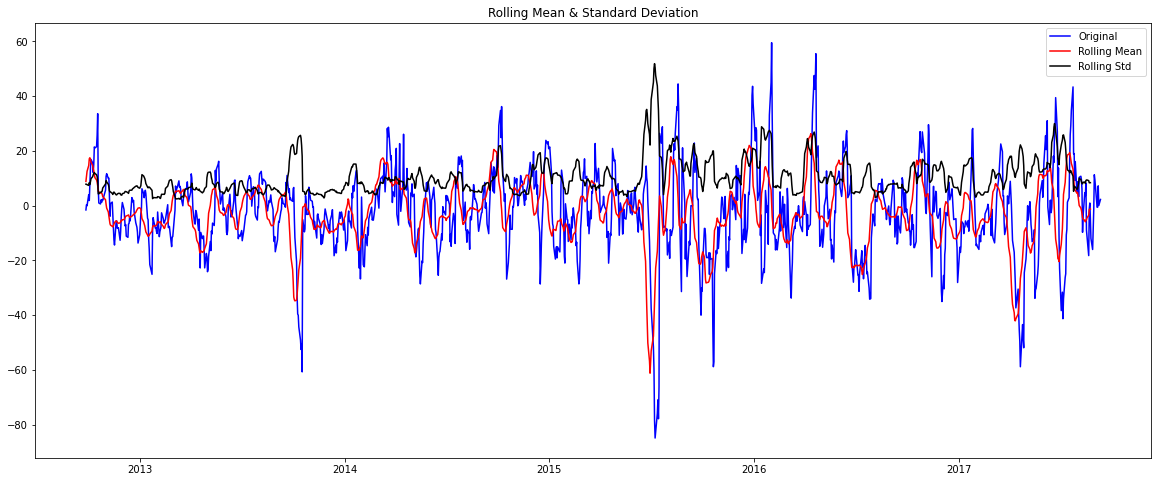

Results of Dickey-Fuller Test:
Test Statistic         -8.057386e+00
p-value                 1.678269e-12
# Lags Used             1.100000e+01
# Observations Used     1.235000e+03
Critical Value (1%)    -3.435656e+00
Critical Value (5%)    -2.863883e+00
Critical Value (10%)   -2.568018e+00
dtype: float64


In [0]:
moving_avg_diff.dropna(inplace=True)
test_stationarity(moving_avg_diff)

From the plot above, the blue original line is the reasult time series after I removing the moving average. Even though it still turbulents, the range now (from -80 ~ 60)  is much smaller than the previous one (from 300~100).

More than that, the P-value= 1.678269e-12 is much more significant now. Hence, I can reject the Null Hypothesis, which means the given series is stationary. 

### 4.2 Exponential Weighted Moving Average

Besides using the simple moving average to transform the series to stationary, another good process is using Exponential Weighted Moving Average, which using the exponential window function to smooth. 

Whereas in the simple moving average the past observations are weighted equally, exponential functions are used to assign exponentially decreasing weights over time, which is often used for analysis of time-series data as well.

The procegre is quite similar.

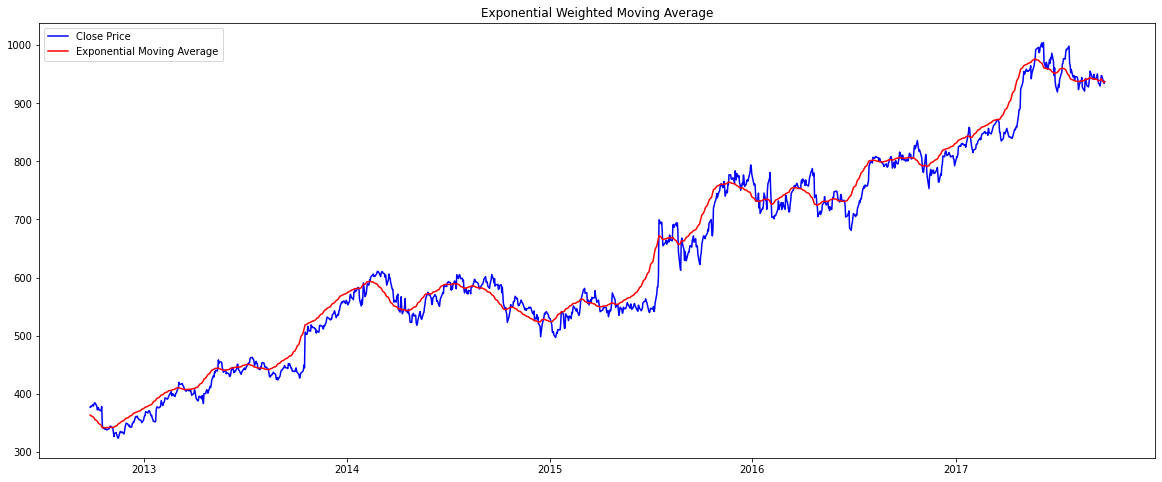

In [0]:
expwighted_avg = stock.Close.ewm(halflife=12).mean()
plt.plot(stock.Close,color='blue',label='Close Price')
plt.plot(expwighted_avg, color='red',label='Exponential Moving Average')
plt.title('Exponential Weighted Moving Average')
plt.legend(loc='best')

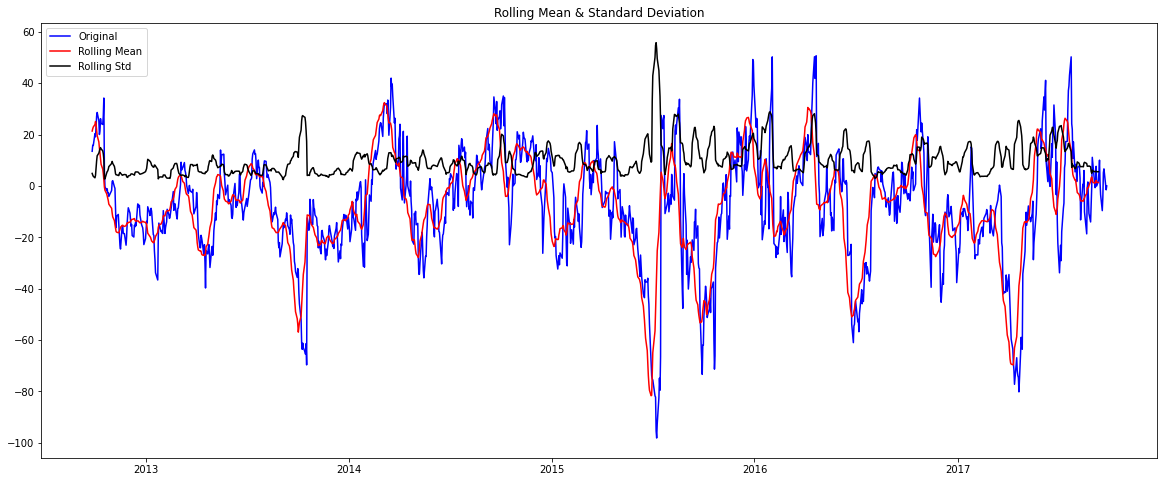

Results of Dickey-Fuller Test:
Test Statistic         -7.113198e+00
p-value                 3.890755e-10
# Lags Used             1.000000e+00
# Observations Used     1.256000e+03
Critical Value (1%)    -3.435567e+00
Critical Value (5%)    -2.863844e+00
Critical Value (10%)   -2.567997e+00
dtype: float64


In [0]:
ewma_diff =stock.Close- expwighted_avg
test_stationarity(ewma_diff)

### 4.3 Differencing Method

We can also usE differencing method to find the diff between todya and tomorrow. It is also a very popular way.

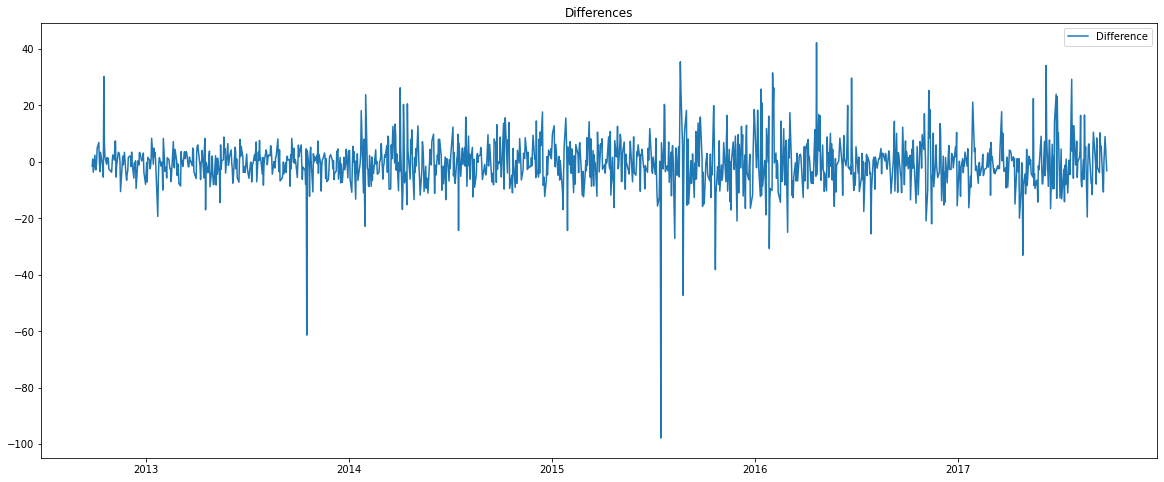

In [0]:
group_diff = stock.Close - stock.Close.shift()
plt.plot(group_diff,label='Difference')
plt.title('Differences')
plt.legend(loc='best')

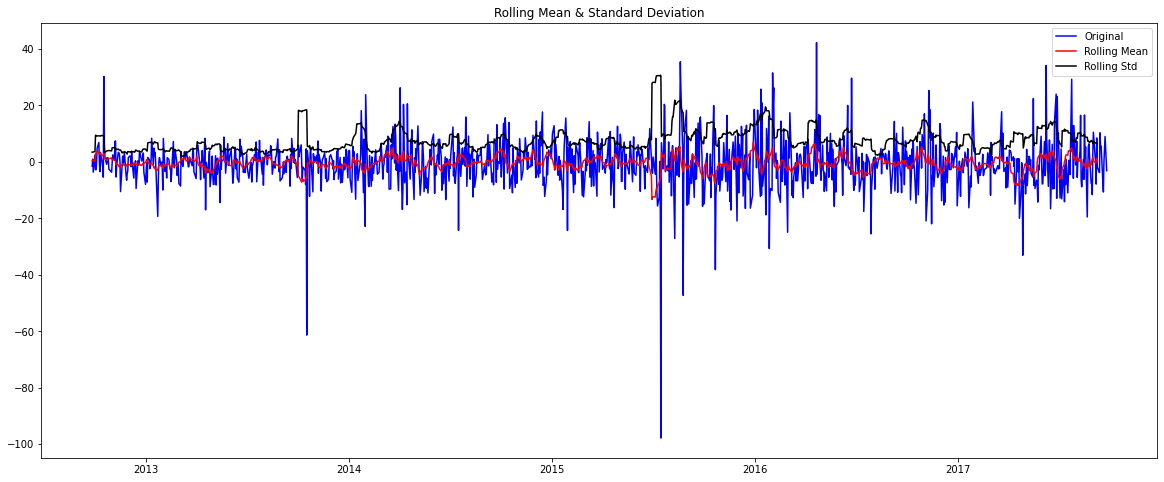

Results of Dickey-Fuller Test:
Test Statistic           -34.011932
p-value                    0.000000
# Lags Used                0.000000
# Observations Used     1256.000000
Critical Value (1%)       -3.435567
Critical Value (5%)       -2.863844
Critical Value (10%)      -2.567997
dtype: float64


In [0]:
group_diff.dropna(inplace=True)
test_stationarity(group_diff)

This time, the result is even better that the p-value=0.000000.


### 4.4 Decomposition Method

The most simple way to de-trend is to use the seasonal_decompose Function. It automaticlly provide me the trend line, seasonality line and the residuel line after decomposing trend and seasonality.

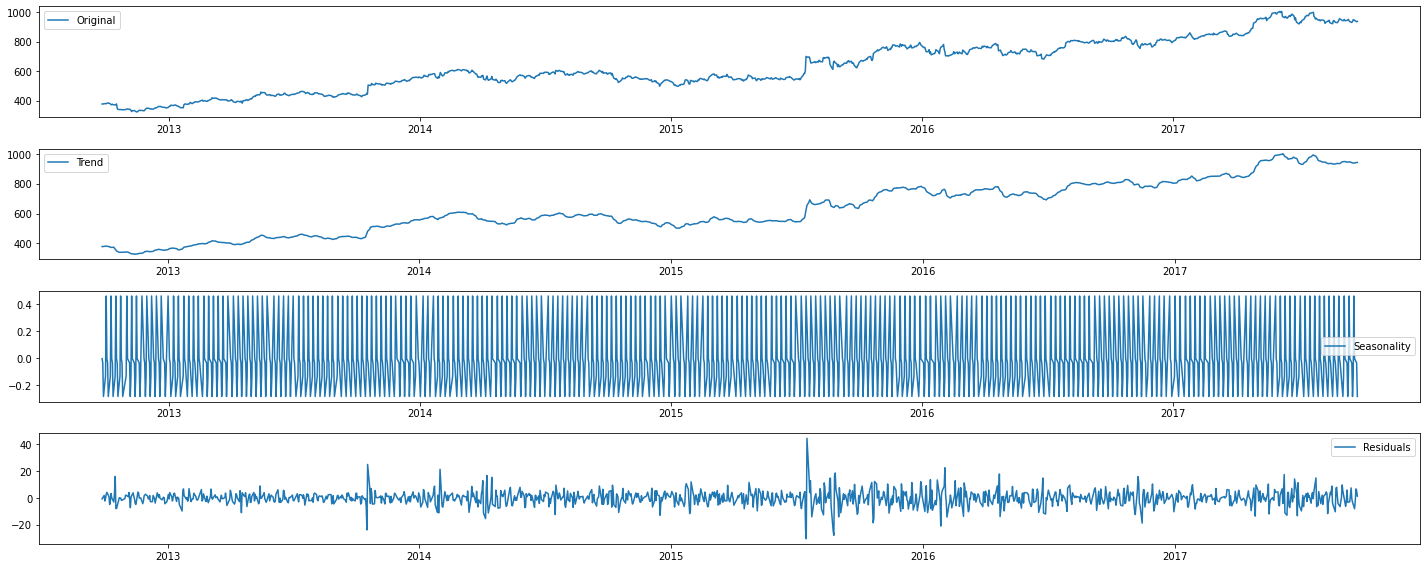

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(stock.Close, freq = 5)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(stock.Close, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


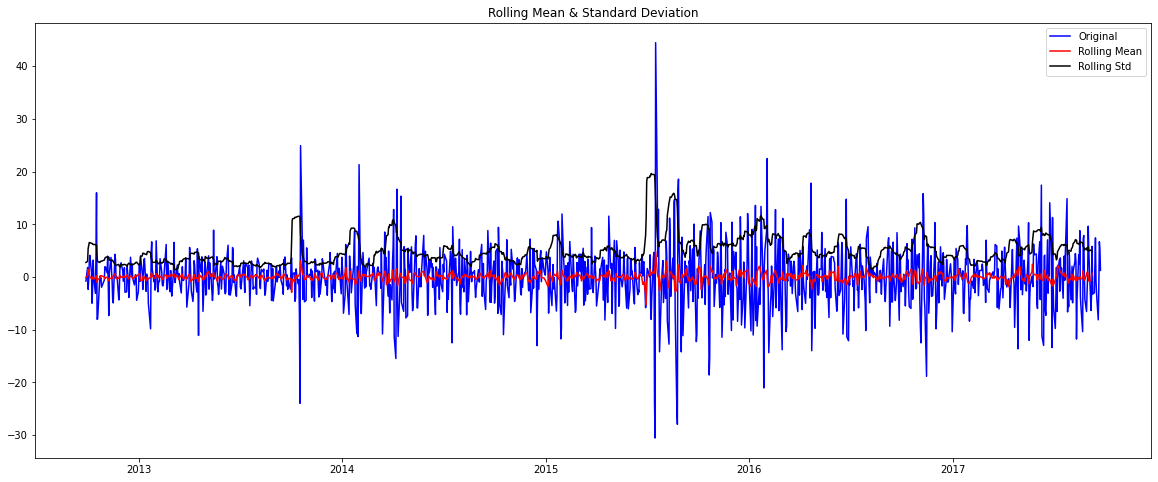

Results of Dickey-Fuller Test:
Test Statistic         -1.549098e+01
p-value                 2.485113e-28
# Lags Used             1.800000e+01
# Observations Used     1.235000e+03
Critical Value (1%)    -3.435656e+00
Critical Value (5%)    -2.863883e+00
Critical Value (10%)   -2.568018e+00
dtype: float64


In [0]:
group_decompose = residual
group_decompose.dropna(inplace=True)
test_stationarity(group_decompose)

The result is pretty good as well. I will keep using the "residual" for future forcasting.

## STEP 5: Modeling Training

Now, I got the stationary "residual" data. In order to choose which model to use (AR,MA,ARIMA), I need to take a look at ACF & PACF, since I will need to choose parameters p,q from the graph.

### 5.1 ACF & PACF

**ACF** is an (complete) auto-correlation function which gives values of auto-correlation of any series with its lagged values. 

In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.


**PACF** is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals with the next lag value. Hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. 


In [0]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(residual, nlags=20)
lag_pacf = pacf(residual, nlags=20, method='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


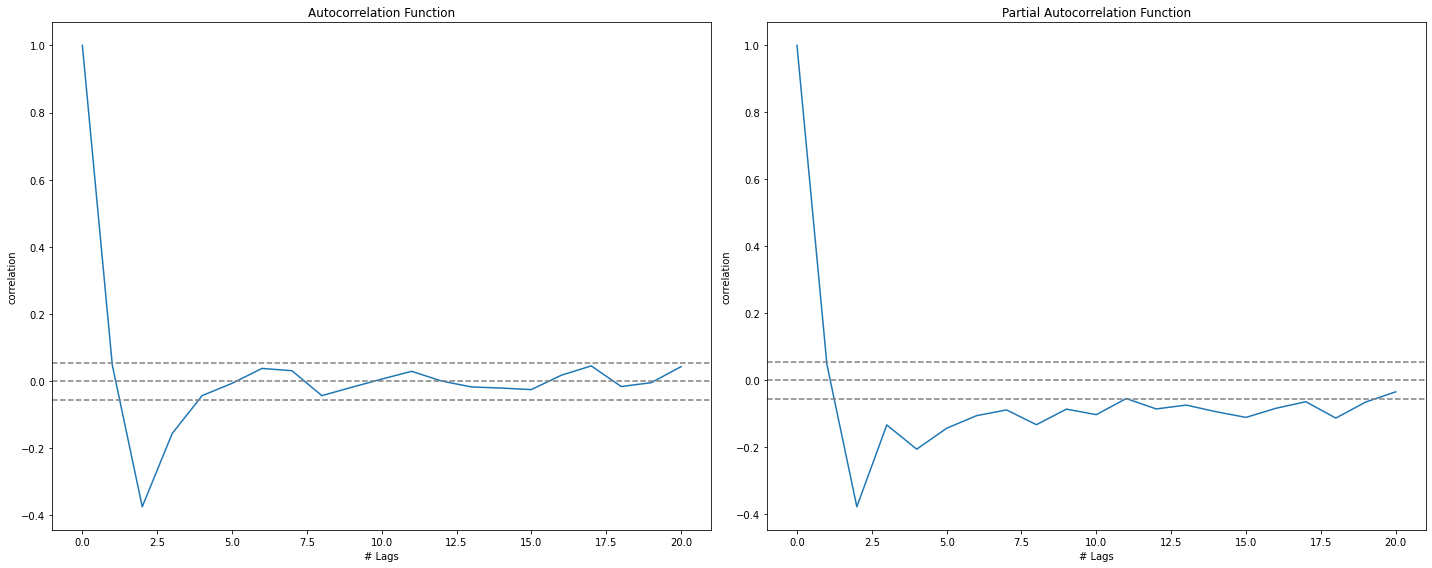

In [0]:
# I use group_diff here because it has the best p-value
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(group_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(group_diff)),linestyle='--',color='gray')
plt.xlabel('# Lags')
plt.ylabel('correlation')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(group_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(group_diff)),linestyle='--',color='gray')
plt.xlabel('# Lags')
plt.ylabel('correlation')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The "--" line here represents the significant level between (-1.96,1.96). From line chart above, I saw the continuously line with no breaks. Hence, it might not be simple AR or MA Model but ARIMA Model. However, for sake of the project exercise, I will still try all three models to see if my guess is right.

### 5.2 AR Model

Auto regressive (AR) process , a time series is said to be AR when present value of the time series can be obtained using previous values of the same time series i.e the present value is weighted average of its past values. Stock prices and global temperature rise can be thought of as an AR processes.

In this project, I will use ARIMA Model, since AR is a special case in ARIMA, no differencing & the set of MA = 0. So I use ARIMA function to fit AR Model.


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'AR Model - RSS: 37472.7383')

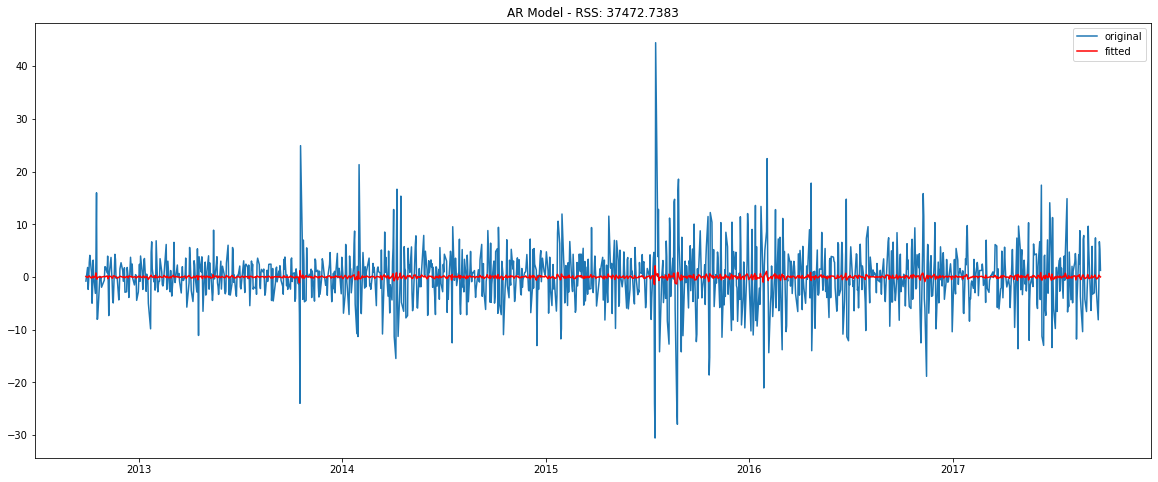

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import aicc

model = ARIMA(residual, order=(1, 0, 0))  
results_AR = model.fit(disp=-1)  

plt.plot(residual,label = 'original')
plt.plot(results_AR.fittedvalues, color='red', label ='fitted')
plt.legend(loc='best')
plt.title('AR Model - RSS: %.4f'% sum((results_AR.fittedvalues-residual)**2))

There are big difference between the original residuel and fitted line. 

### 5.3 MA Model

Now let’s do the second type of process,
Moving average (MA) process, a process where the present value of series is defined as a linear combination of past errors. 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'MR Model - RSS: 37266.0572')

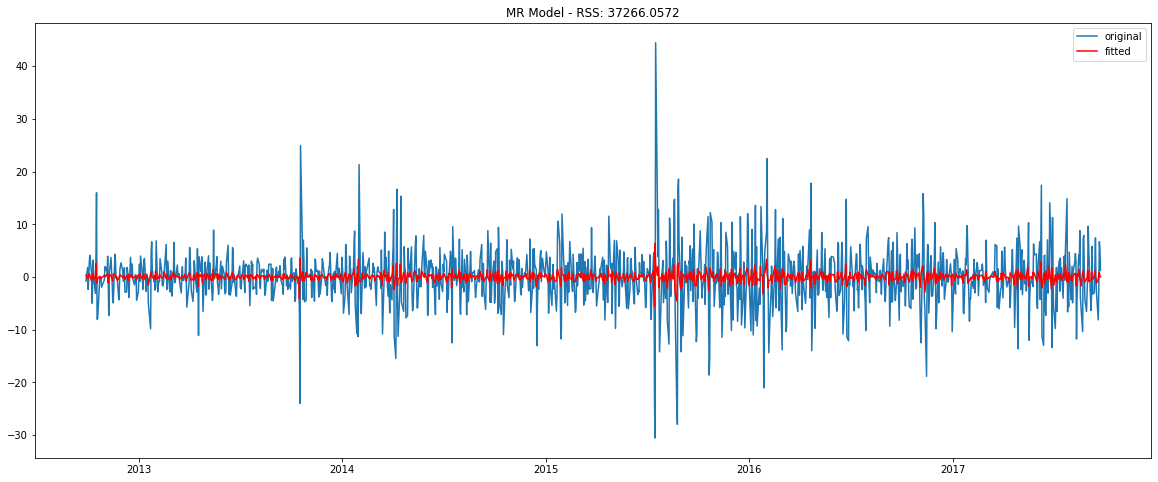

In [0]:
model = ARIMA(residual, order=(0,0,1))  
results_MA = model.fit(disp=-1)  
plt.plot(residual,label = 'original')
plt.plot(results_MA.fittedvalues, color='red',label = 'fitted')
plt.legend(loc='best')
plt.title('MR Model - RSS: %.4f'% sum((results_MA.fittedvalues-residual)**2))

MA is slightly better than AR Model with better fitted line and smaller RSS. However, it is still not good enought. Let's try ARIMA.


### 5.4 ARIMA Mode


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'ARIMA Model - RSS: 29562.7636')

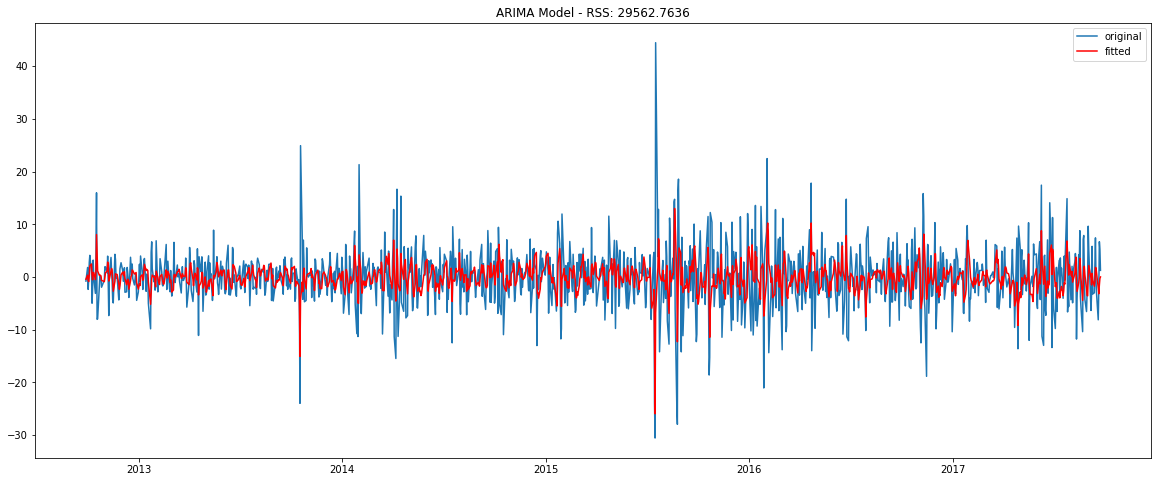

In [0]:
model = ARIMA(residual, order=(1, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(residual,label = 'original')
plt.plot(results_ARIMA.fittedvalues, color='red',label = 'fitted')
plt.legend(loc='best')
plt.title('ARIMA Model - RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual)**2))

It's better than AR & MA, but still not perfect. It is probably beacuse of the choose of parameter p & q, since there are not much information from ACF & PACF Plot.

Hence, the next step is to use grid search to find the best parameters for ARIMA Model.

### 5.5 Grid Seach for p & q

In [0]:
mat_aic = np.zeros((5,5))
for p in range(1, 6):
  for q in range(1, 6):
    try:
      model = ARIMA(residual, order=(p, 0, q))  
      results_ARIMA = model.fit(disp=-1)  
      mat_aic[p-1][q-1] = results_ARIMA.aic
    except:
      print("not invertible")

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

not invertible
not invertible
not invertible
not invertible


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

In [0]:
print(mat_aic)

[[7529.31742294    0.            0.            0.            0.        ]
 [7380.12126432 7361.31775107 7360.83312965 7362.28958009 7364.09494074]
 [7368.12445524 7362.30753423 7363.96064794 7362.33529992 7360.97044366]
 [7362.12662422 7363.50507516 7364.24343307 7362.5948717  7362.84528788]
 [7363.54156289 7363.50802343 7366.12728939 7367.19470874 7364.14993692]]


From the matrix above, the best AIC score is 7360.83312965 (the smaller, the better), which means the best p,q in the range I set, is p=2,q=3.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


7360.833129647841


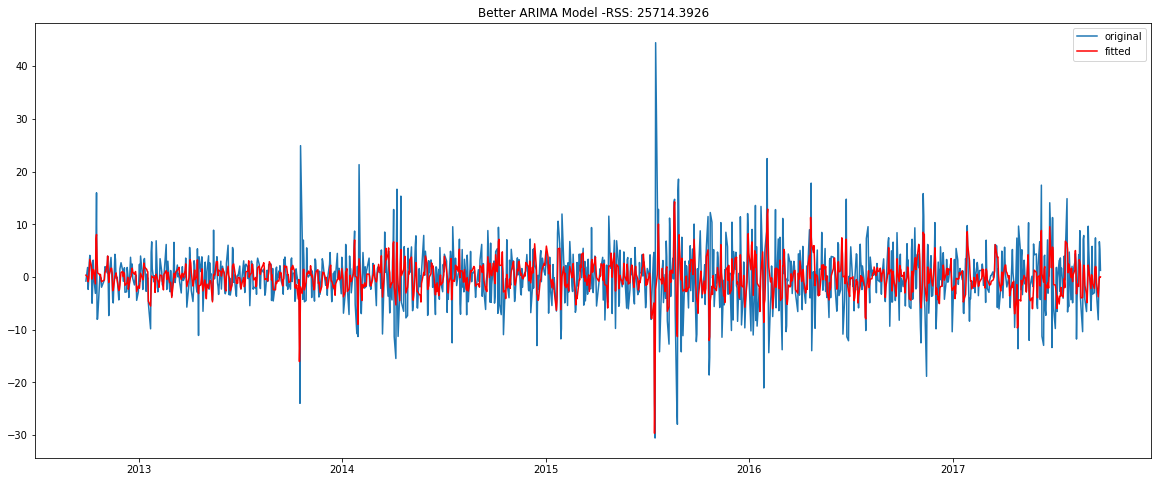

In [0]:
model = ARIMA(residual, order=(2, 0, 3))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(residual,label = 'original')
plt.plot(results_ARIMA.fittedvalues, color='red',label='fitted')
plt.legend(loc='best')
plt.title('Better ARIMA Model -RSS: %.4f'% sum((results_ARIMA.fittedvalues-residual)**2))
print(results_ARIMA.aic)

In [0]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 1254
Model:                     ARMA(2, 3)   Log Likelihood               -3673.417
Method:                       css-mle   S.D. of innovations              4.516
Date:                Thu, 09 Apr 2020   AIC                           7360.833
Time:                        03:07:24   BIC                           7396.772
Sample:                             0   HQIC                          7374.342
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0002      0.001     -0.332      0.740      -0.001       0.001
ar.L1.Close     1.0378        nan        nan        nan         nan         nan
ar.L2.Close    -0.2750      0.031     -8.832    

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Overall, it seems to be a good fit. Let’s see the performance of the model and how it fits the original Google stock prices.

## STEP 6: Fitting & Evaluation

### 6.1 Fit the ARIMA Model

First, I need to take it back to original scale and add back trend and seasonality to the ARIMA Model. Then I can see the performance of the Final Model.

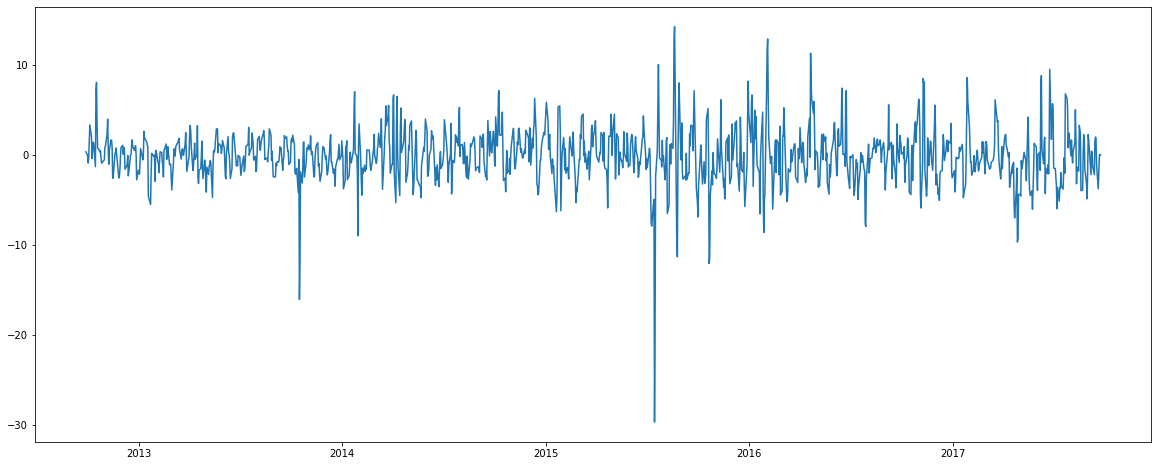

In [0]:
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA.head()
plt.plot(predictions_ARIMA)

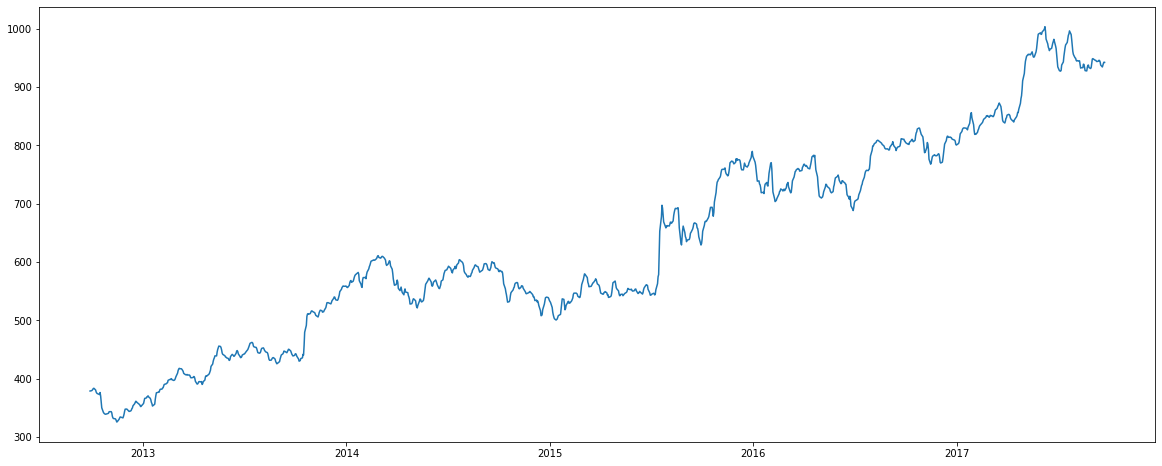

In [0]:
predictions_all = pd.Series(0, index=stock.Close.index)
predictions_all = predictions_all.add(trend).add(seasonal).add(predictions_ARIMA)
predictions_all.head()
plt.plot(predictions_all)

Text(0.5, 1.0, 'Original vs. Fitted Line')

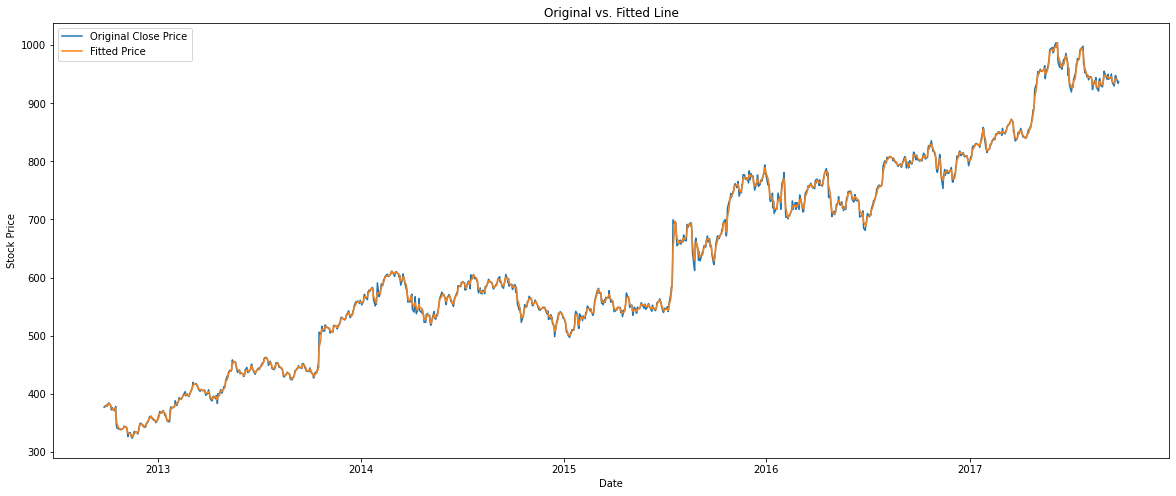

In [0]:
plt.plot(stock.Close,label='Original Close Price')
plt.plot(predictions_all,label='Fitted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend(loc='best')
plt.title('Original vs. Fitted Line')

### 6.2 Model Evaluation

As you can see the model did quite handsomely. Let us also check the commonly used accuracy metrics to judge the fitting results.

However, I need to match the window index for original data and fitted results.

In [0]:
predictions_all.isnull().sum()

0

In [0]:
predictions_all.dropna(inplace=True)
original_price = pd.Series(stock.Close, index=predictions_all.index)

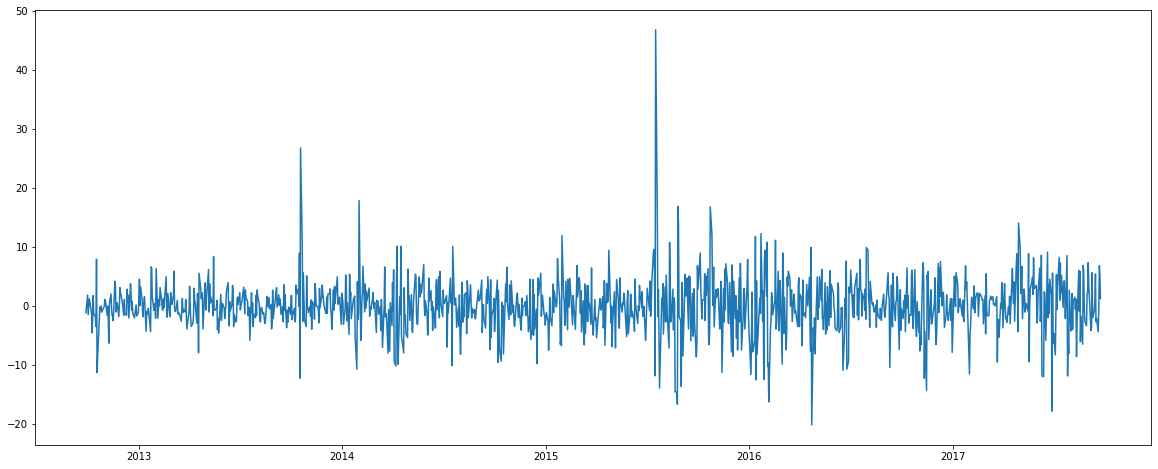

In [0]:
error = original_price - predictions_all
plt.plot(error)

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# report performance
mse = mean_squared_error(original_price, predictions_all)
print('MSE: '+str(mse))
mae = mean_absolute_error(original_price, predictions_all)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(original_price, predictions_all))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions_all-original_price)/np.abs(original_price))
print('MAPE: '+str(mape))

MSE: 20.505895240453597
MAE: 3.1873241130252086
RMSE: 4.528343542671381
MAPE: 0.005131187080046023


Around 0.5% MAPE(Mean Absolute Percentage Error) implies the model is about 99.5% accurate in fitting the data set observations.

**Conclusion**

In this project, the data has been collected from kaggle.com. The historical Google Stock Price data from the year 12012 to 2017 were taken in to account for analysis. 

The ARIMA model is trained, predicted the stock prices on the original dataset with 99.5% accurancy.